In [2]:
import pandas as pd
import time
from datetime import datetime
from pandas import ExcelWriter 
pd.__version__

import random
import matplotlib.pyplot as plt
#from matplotlib import style
from matplotlib.pyplot import figure
import matplotlib.dates as mdates
%matplotlib inline

In [3]:
class JTLReader:
    def __init__(self,jtlPath):
        self.jtlPath=jtlPath
        self.jtlColumns = ['timeStamp', 'elapsed','label','bytes','allThreads','responseCode']
        %time self.df_Jtl=pd.read_csv(self.jtlPath,usecols=self.jtlColumns,dtype={'label':'category'})#,nrows=100     
        self.shape=self.df_Jtl.shape
        self.rows=self.shape[0]
        self.rows     
       
        
    def converTimeStamp(self):
        self.df_Jtl['timeStamp'] = pd.to_datetime(self.df_Jtl['timeStamp'],unit='ms')
        self.df_Jtl['timeStamp'] = self.df_Jtl['timeStamp'].astype('datetime64[s]')#reduce precision pandas timestamp dataframe
        self.df_Jtl['timeStamp']=self.df_Jtl['timeStamp'].dt.tz_localize('utc').dt.tz_convert('Singapore')
        self.df_Jtl['timeStamp'] = self.df_Jtl['timeStamp'].astype(str).str[:-6]
        self.df_Jtl['timeStamp'] = pd.to_datetime(self.df_Jtl['timeStamp'])
        self.df_Jtl['timeStamp'] = self.df_Jtl['timeStamp'].astype('datetime64[s]') 
        
    def ms_to_sec(self):
         self.df_Jtl['elapsed']=(self.df_Jtl['elapsed']/1000)  
        
    def overAllResponseTimeSummary(self):
        self.df_overAllResponseTimeSummary=self.df_Jtl[['timeStamp','elapsed']]
        return self.df_overAllResponseTimeSummary
    
    def responseTimeSummary(self):
        self.df_responseTimeSummary=self.df_Jtl[['label','elapsed']]
        self.df_txnGroup=self.df_responseTimeSummary.groupby(['label'])
        self.df_txnGroup=self.df_txnGroup.elapsed.describe(percentiles=[.90])#self.df_txnGroup.describe(percentiles=[.90])
        self.df_txnGroup.columns=self.df_txnGroup.columns.get_level_values(0)#self.df_txnGroup.columns=self.df_txnGroup.columns.get_level_values(1)
        self.df_txnGroup = self.df_txnGroup[['min','mean','90%','max','count']]
        #self.df_txnGroup=self.df_txnErrorGroup.reset_index() """To be enable if you run describe () on data frame. Now we are running on specific column"""
        return self.df_txnGroup
    
    def errorSummary(self):
        self.df_errorSummary=self.df_Jtl[['label','responseCode']]
        self.df_txnErrorGroup=self.df_errorSummary.groupby(['label'])
        self.df_txnErrorGroup=self.df_txnErrorGroup.responseCode.describe()
        return self.df_txnErrorGroup
    
        
    def calculateErrorPercentage(self,responseTimeSummary,errorSummary):
        #Method 1
        self.txn_grp=self.df_Jtl.groupby(['label'])
        #return self.txn_grp.get_group('BP01_TX05_Submit')
        
        #Method 2
        #filt=self.df_Jtl['label']=='BP01_TX05_Submit'
        #return self.df_Jtl.loc[filt]['responseCode'].value_counts()
        
        #Method 3
        #self.txn_grp=self.df_Jtl.groupby(['label'])
        #return self.txn_grp['responseCode'].value_counts(normalize=True)
        
        #self.df_responseTimeSummary=responseTimeSummary
        #self.df_errorSummary=errorSummary
        #self.response_error=pd.merge(self.df_responseTimeSummary,self.df_errorSummary)
        # return self.response_error
        return self.txn_grp.get_group('DS53_Bids - Bid Validation Status Retrieval')
  
    def listOfErrors(self):
        return self.df_Jtl['responseCode'].value_counts()
    
    def shapeOfDaraFrame(self):
        return self.df_Jtl.shape
    
    def columnType(self,columnName):
        self.columnName=columnName
        return self.df_Jtl[self.columnName].dtype
    
    def getPeriod(self):
        self.startTime=self.df_Jtl['timeStamp'][0]
        self.endRow=self.df_Jtl['timeStamp'].shape[0]
        self.endTime=self.df_Jtl['timeStamp'][self.endRow-1]
        return f'{self.startTime} : {self.endTime}'
    
    def getDuration(self):
        self.startTime=self.df_Jtl['timeStamp'][0]
        self.endRow=self.df_Jtl['timeStamp'].shape[0]
        self.endTime=self.df_Jtl['timeStamp'][self.endRow-1]
        self.executionStartTime=datetime(self.startTime.year,self.startTime.month,self.startTime.day,self.startTime.hour,self.startTime.minute,self.startTime.second)
        self.executionEndTime=datetime(self.endTime.year,self.endTime.month,self.endTime.day,self.endTime.hour,self.endTime.minute,self.endTime.second)
        self.timeDiff = self.executionEndTime-self.executionStartTime
        self.duration_in_s = self.timeDiff.total_seconds()
        self.duration=time.strftime("%H:%M:%S", time.gmtime(self.duration_in_s))
        return self.duration
    
    def getMaxRunningVusers(self):
        self.allThread=self.df_Jtl['allThreads'].max()
        return self.allThread 
        
    def getTotalThroughput(self):
        self.totalThroughput=self.df_Jtl['bytes'].sum()
        return self.totalThroughput
    
    def getAvgThroughputPerSecond(self):
        self.avgThroughput=self.df_Jtl['bytes'].sum()/self.duration_in_s
        return self.avgThroughput
    
    def getTotalHits(self):
        return self.rows
    
    def getAvgHitsPerSecond(self):
        return self.rows/self.duration_in_s
    
    def getTotalErrors(self):
        return         

    def getAnalysisSummary(self):
        self.period=self.getPeriod()
        self.duration=self.getDuration()
        self.maxRunningVusers=self.getMaxRunningVusers()
        self.totalThroughput=self.getTotalThroughput()
        self.avgThroughputPerSecond=self.getAvgThroughputPerSecond()
        self.totalHits=self.getTotalHits()
        self.avgHitsPerSecond=self.getAvgHitsPerSecond()
        
        self.df_AnalysisSummary=pd.DataFrame(
            {
                'Data':[
                        'Period','Duration','Maximum Running Vusers','Total Throughput(bytes)',
                        'Average Throughput(bytes/Second)','TotalHits','Average Hits Per Second',
                        'Total Error','Total Pass','Total Failed'
                ],
                'Values':[
                            self.period,self.duration,self.maxRunningVusers,self.totalThroughput,
                            self.avgThroughputPerSecond,self.totalHits,self.avgHitsPerSecond,
                            'NA','NA','NA'
                ]
                
            }
        )
        return self.df_AnalysisSummary
    
    def getRunnerVuserGraphData(self):
        '''T=min,S=Seconds'''        
        self.df_vusers=self.df_Jtl[['timeStamp','allThreads']]
        self.df_vusers.sort_values(by=['timeStamp'])
        self.df_vusers.set_index('timeStamp',inplace=True)
        self.df_vusers_summary = pd.DataFrame()
        self.df_vusers_summary['vusersCount']=self.df_vusers['allThreads'].resample('30T').max()     
        return self.df_vusers_summary
    
    def getHitsPersecondGraphData(self):
        '''T=min,S=Seconds'''
        self.df_Jtl['hits']=1
        self.df_hits=self.df_Jtl[['timeStamp','hits']]
        self.df_hits.sort_values(by=['timeStamp'])
        self.df_hits.set_index('timeStamp',inplace=True)
        self.df_hits_summary = pd.DataFrame()
        self.df_hits_summary['hitsCount']=self.df_hits['hits'].resample('30T').sum()     
        return self.df_hits_summary
    
    def getThrouhputPersecondGraphData(self):
        '''T=min,S=Seconds'''
        self.df_throughput=self.df_Jtl[['timeStamp','bytes']]
        self.df_throughput.sort_values(by=['timeStamp'])
        self.df_throughput.set_index('timeStamp',inplace=True)
        self.df_throughput_summary = pd.DataFrame()
        self.df_throughput_summary['Throughput']=self.df_throughput['bytes'].resample('30T').sum()     
        return self.df_throughput_summary
    
    
      
obj1=JTLReader("C:\\Karthik\\Pandas\\result.jtl") 
obj1.converTimeStamp()
obj1.ms_to_sec() 



Wall time: 203 ms


In [10]:
throughput=obj1.getThrouhputPersecondGraphData()
throughput

,Throughput
timeStamp,
2020-03-27 11:30:00,40741650
2020-03-27 12:00:00,39367382


In [11]:
runningVuser=obj1.getRunnerVuserGraphData()
runningVuser

,vusersCount
timeStamp,
2020-03-27 11:30:00,2
2020-03-27 12:00:00,2


In [12]:
hitsPersecond=obj1.getHitsPersecondGraphData() 
hitsPersecond

,hitsCount
timeStamp,
2020-03-27 11:30:00,3096
2020-03-27 12:00:00,2990


In [13]:
obj1.getPeriod()

'2020-03-27 11:43:48 : 2020-03-27 12:12:20'

In [14]:
obj1.getDuration()

'00:28:32'

In [15]:
obj1.getMaxRunningVusers()

2

In [16]:
obj1.gerTheroughput()

AttributeError: 'JTLReader' object has no attribute 'gerTheroughput'

In [4]:
analysisSummary=obj1.getAnalysisSummary()
analysisSummary

,Data,Values
0,Period,2020-03-27 11:43:48 : 2020-03-27 12:12:20
1,Duration,00:28:32
2,Maximum Running Vusers,2
3,Total Throughput(bytes),80109032
4,Average Throughput(bytes/Second),46792.7
5,TotalHits,6086
6,Average Hits Per Second,3.55491
7,Total Error,NA
8,Total Pass,NA
9,Total Failed,NA


In [5]:
obj1.listOfErrors()

200                                                                      6074
Non HTTP response code: org.apache.http.conn.HttpHostConnectException      12
Name: responseCode, dtype: int64

In [6]:
#responseTimeSummary
responseTimeSummary=obj1.responseTimeSummary()
responseTimeSummary

,min,mean,90%,max,count
label,,,,,
/-1,0.475,0.661967,0.6890,1.461,508.0
/login.php-4,1.445,1.532559,1.5680,2.186,508.0
/mercurypurchase.php-11,0.552,0.774040,0.8145,1.397,506.0
/mercurypurchase2.php-16,0.532,0.996937,0.9990,21.347,506.0
/mercuryreservation2.php-8,0.759,0.996527,1.0014,21.030,507.0
/mercurysignoff.php-23,0.511,0.750984,0.7997,21.044,504.0
BP01_TX01_Launch URL,0.475,0.661967,0.6890,1.461,508.0
BP01_TX02_Login,1.445,1.532602,1.5680,2.186,508.0
BP01_TX03_Continue1,0.759,0.996527,1.0014,21.030,507.0


In [7]:
#overAllResponseTimeSummary
obj1.overAllResponseTimeSummary()


,timeStamp,elapsed
0,2020-03-27 11:43:48,0.611
1,2020-03-27 11:43:48,0.611
2,2020-03-27 11:43:48,0.588
3,2020-03-27 11:43:48,0.588
4,2020-03-27 11:43:48,1.508
...,...,...
6081,2020-03-27 12:12:19,0.804
6082,2020-03-27 12:12:20,0.947
6083,2020-03-27 12:12:20,0.947
6084,2020-03-27 12:12:20,0.974


In [17]:
writer = ExcelWriter('PythonExport.xlsx')
#Write Analysis Summary to Excel
analysisSummary.to_excel(writer,sheet_name='AnalysisSummary')
#write response summary to excel with txn name,min,avg,max,90% & max
responseTimeSummary.to_excel(writer,sheet_name='ResponseSummary')
#Write Running Vusers
runningVuser.to_excel(writer,sheet_name='RunningVuserSummary')
#Write Hits Summary
hitsPersecond.to_excel(writer,sheet_name='HitsSummary')
#Write Throughput Summary
throughput.to_excel(writer,sheet_name='ThroughputSummary')

writer.save()

In [18]:
errorSummary=obj1.errorSummary()
errorSummary

,count,unique,top,freq
label,,,,
/-1,508,1,200,508
/login.php-4,508,1,200,508
/mercurypurchase.php-11,506,1,200,506
/mercurypurchase2.php-16,506,2,200,503
/mercuryreservation2.php-8,507,2,200,506
/mercurysignoff.php-23,504,2,200,502
BP01_TX01_Launch URL,508,1,200,508
BP01_TX02_Login,508,1,200,508
BP01_TX03_Continue1,507,2,200,506


In [44]:
ser=obj1.calculateErrorPercentage(responseTimeSummary,errorSummary)
ser

label                         responseCode
DS01_AdvisoriesRetrieval      200             0.822928
                              200             0.175936
                              500             0.001135
DS02_PenaltyReports - PEN001  200             0.864125
                              200             0.135814
                                                ...   
DS57_Bids - Pre Validate      200             0.134318
DS58_Bids - Get Batch Status  200             0.888365
                              200             0.111635
Ds03_PenaltyReports - PEN002  200             0.865226
                              200             0.134774
Name: responseCode, Length: 151, dtype: float64

In [50]:
ser1=obj1.calculateErrorPercentage(responseTimeSummary,errorSummary)
writer = ExcelWriter('PythonExport.xlsx')
ser1.to_excel(writer,sheet_name='DS53_BidsBidValidatio')
writer.save()

In [19]:
df=ser.unstack()
df

NameError: name 'ser' is not defined

In [307]:
df.loc[:,'Non HTTP response code: org.apache.http.conn.HttpHostConnectException']

label
/-1                                NaN
/login.php-4                       NaN
/mercurypurchase.php-11            NaN
/mercurypurchase2.php-16      0.005929
/mercuryreservation2.php-8    0.001972
/mercurysignoff.php-23        0.003968
BP01_TX01_Launch URL               NaN
BP01_TX02_Login                    NaN
BP01_TX03_Continue1           0.001972
BP01_TX04_Continue2                NaN
BP01_TX05_Logoff              0.003968
BP01_TX05_Submit              0.005929
DeleteUserName                     NaN
GetUserName                        NaN
Name: Non HTTP response code: org.apache.http.conn.HttpHostConnectException, dtype: float64

In [20]:
obj1.calculateErrorPercentage()

TypeError: calculateErrorPercentage() missing 2 required positional arguments: 'responseTimeSummary' and 'errorSummary'

In [81]:
temp=obj1.columnType('responseCode')
temp


dtype('O')

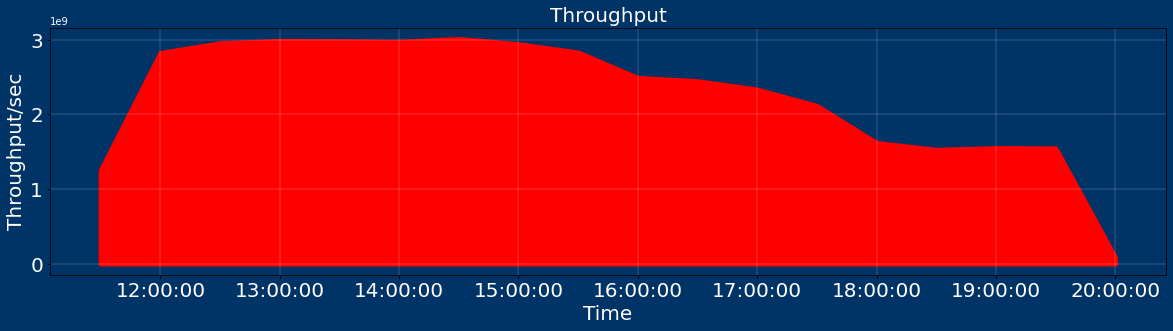

In [34]:
import random
import matplotlib.pyplot as plt
#from matplotlib import style
from matplotlib.pyplot import figure
import matplotlib.dates as mdates
%matplotlib inline


#print(plt.style.available)
#print(plt.__file__)

#style.use('dark_background')
plt.rcParams['figure.figsize']=[25,18]
fig = plt.figure(figsize=(20,10))
fig.set_facecolor('#003366')

# Add suplot syntax

ax1 = fig.add_subplot(211)

#To get data for x and y axis
x,y=Throughput.index,Throughput['Throughput']
#To rotate 
for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(0)

#To print x axis with date and time
xfmt = mdates.DateFormatter('%H:%M:%S')#%d-%m-%y %H:%M:%S//ax.xaxis_date()
ax1.xaxis.set_major_formatter(xfmt)
ax1.fill_between(x,y,color="red",linewidth=5)#https://matplotlib.org/users/dflt_style_changes.html

# x and y label
ax1.set_xlabel('Time',fontsize=20,color='white')#alpha=0.3
ax1.set_ylabel('Throughput/sec',fontsize=20)
ax1.set_title('Throughput',fontsize=20,color='white')

#To drwa 4 lines with the desier colour : Top,Bottom,Left and Right
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.spines['right'].set_color('black')

#
ax1.xaxis.label.set_color('white')#"Time"
ax1.yaxis.label.set_color('white')#"HitsPerMin"

ax1.tick_params(axis='x', labelcolor='white',labelsize=20)#"%d-%m-%y %H:%M:%S"
ax1.tick_params(axis='y', labelcolor='white',labelsize=20)#"Hits Count: 10,20,30,40,50,60,70"

ax1.set_facecolor('#003366')#https://matplotlib.org/users/colors.html

##003366

ax1.grid(which='major', linestyle='-', linewidth='0.2', color='white')#17becf
#ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='red')

#ax1.set_yticks([0,1,2,3,4,5,6,7,8,9,10])
#ax1.set_xticks(['22:00:00','22:30:00','23:00:00','23:30:00','00:00:00',
               # '00:30:00','01:00:00','01:30:00','02:00:00','02:30:00',
               # '03:00:00','03:30:00','04:00:00','04:30:00'])
#ax.set_ylim((0, 6))
#ax.set_xlim()

#fig.savefig("E:\MaxUser.pdf",dpi=None,facecolor='#003366', edgecolor='#003366',bbox_inches='tight')
plt.show()